# SOCIB Modelling and Forecasting Facility - MFF Python Library Tutorials
## Generating Particles Locations
---

#### **Importing the MFF module and the Particles Generator**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
import socib_modelling_python as mff
from socib_modelling_python.batch.generate_particles import GenerateParticles

INFO: Compiled ParcelsRandom ==> /tmp/parcels-19211/libparcels_random_b7d6ca17-ef97-4371-ab9e-4b1de9895120.so


In [4]:
from socib_modelling_python.plot.mff_maps import plot_points_map

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import NearestNDInterpolator

#### **GenerateParticles Class**
GenerateParticles is a class that contains different methods to generate particles.  
All methods returns three lists (numpy arrays) with the latitude, longitude, and depth of each particle.
The available methods are:
* random : Generate a set of particles randomly spread.
* at_location : Generate a set of particles at a specific location.
* regular : Generate a set of particles regularly spread.
* from_grid : Generate a set of particles matching the grid point locations.  

In this tutorial we will use our built-in function plot_points_map (from mff_maps) to show the particles' locations  

---

#### **Generating particles randomly and limited by some coordinates**

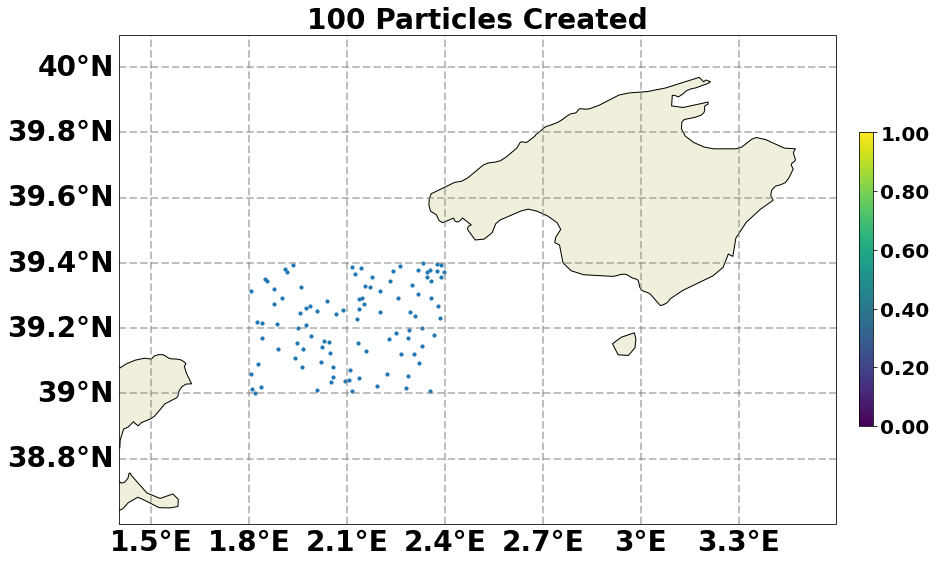

In [6]:
n_particles = 100
lat_limits = (39, 39.4)
lon_limits = (1.8, 2.4)
lats, lons, depths = GenerateParticles.random(n_particles, lat_limits=lat_limits, lon_limits=lon_limits)
plot_points_map(lons, lats, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

#### **Generating particles randomly and limited by a predefined region**

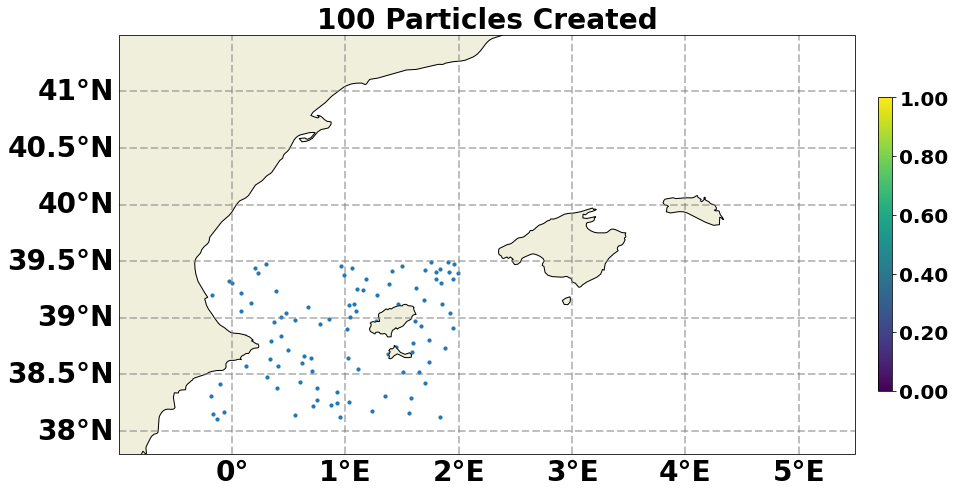

In [7]:
n_particles = 100
lats, lons, depths = GenerateParticles.random(n_particles, region='IbizaChannel')
plot_points_map(lons, lats, show=True, region='BalearicIslands', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

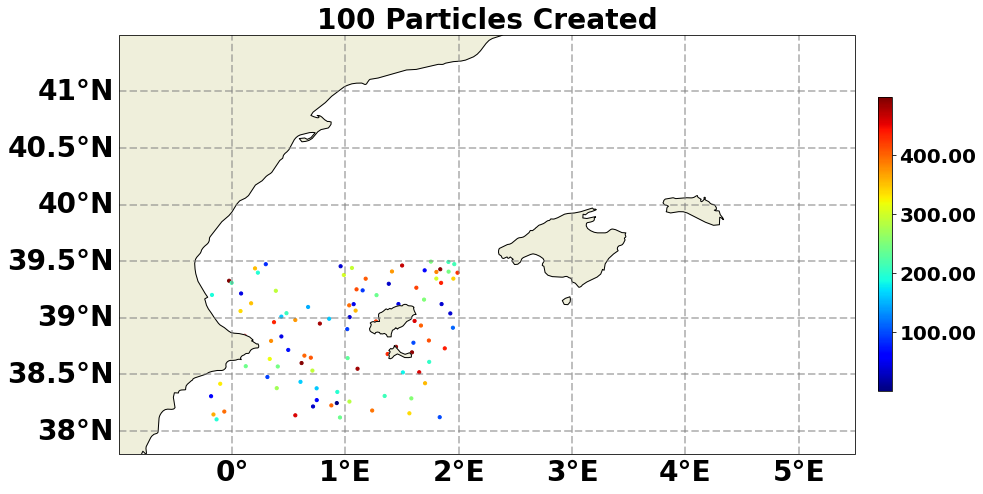

In [8]:
n_particles = 100
depth_limits = (0, 500)
lats, lons, depths = GenerateParticles.random(n_particles, region='IbizaChannel', depth_limits=depth_limits)
plot_points_map(lons, lats, hue=depths, show=True, region='BalearicIslands', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

#### **Generating particles in a single location**

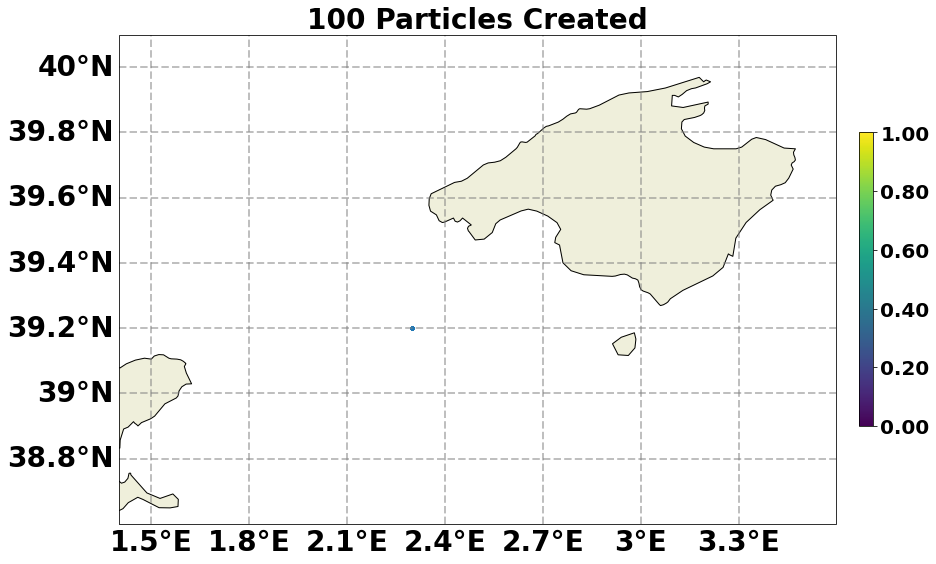

In [9]:
n_particles = 100
lats, lons, depths = GenerateParticles.at_location(n_particles, 39.2, 2.3)
plot_points_map(lons, lats, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

Including a **dispersion** factor (in meters) around latitude and longitude values.  
For each particle and each coordinate separately, a random value between 0 and dispersion is add to the coordinate.

In [10]:
n_particles = 100
lats, lons, depths = GenerateParticles.at_location(n_particles, 39.2, 2.3, dispersion=5_000)
plot_points_map(lons, lats, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

#### **Generating particles regularly distributed**
This method distributes particles along an area keeping a separation distance defined by the user.  
Note that, in this method, the final particles do not necessarily have a shape like a grid.  
Because, depending on the latitude, more or fewer particles will fit along the longitude dimension. 

In [11]:
lat_limits = (39, 39.4)
lon_limits = (1.8, 2.4)
depth_limits = (0, 100)
lat_separation = 3_000  # in meters
lon_separation = 5_000  # in meters
dep_separation = 10
lats, lons, depths = GenerateParticles.regular(lat_limits=lat_limits, lon_limits=lon_limits, # depth_limits=depth_limits,
                                               lat_separation=lat_separation, lon_separation=lon_separation, depth_separation=dep_separation)
plot_points_map(lons, lats, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

#### **Generating particles in all points of a grid**

In [12]:
wmop = xr.open_dataset('../../socib_modelling_python/tests/batch/data/roms_wmop_regular_his_velocities_mallorca.nc')

In [13]:
grid = xr.open_dataset("/mnt/waverider/home/modelling/Softs/ROMS-3.4/WMOPv2.0/Grid/roms_grd_WMOPv2.0.nc")

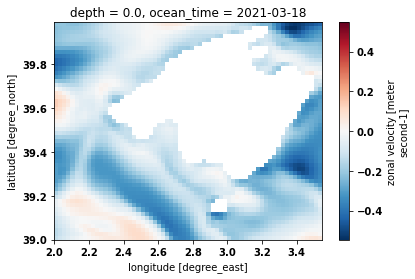

In [14]:
plt.figure()
wmop.isel(ocean_time=0, depth=0).squeeze().u.plot()
plt.show()

In [15]:
lats, lons, depths = GenerateParticles.from_grid(wmop, latitude='lat', longitude='lon')
plot_points_map(lons, lats, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

#### **Generating particles in all points of a grid, avoiding land**

Creating a landing mask

In [16]:
da = wmop['w'].isel(ocean_time=0)
land = np.isnan(da)
wmop['land_mask'] = land

land_mask_coords = {
    'latitude': 'lat',
    'longitude': 'lon',
    'depth': 'depth'
}

Passing the land_mask parameters to the generator

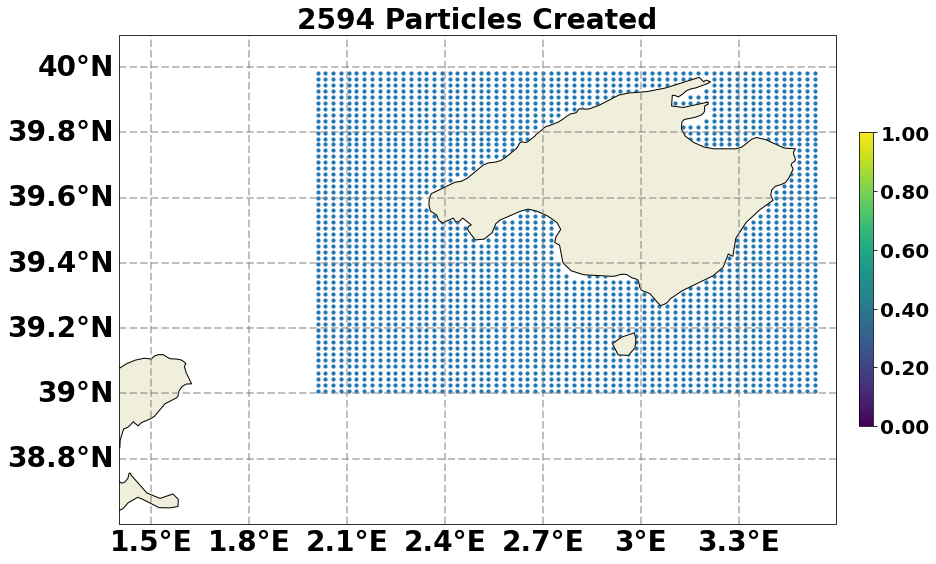

In [17]:
lats, lons, depths = GenerateParticles.from_grid(wmop, latitude='lat', longitude='lon', land_mask=wmop.land_mask, land_mask_coords=land_mask_coords)
plot_points_map(lons, lats, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

#### **Generating particles regularly distributed over a IxJxK grid**
From a referential point, this method creates a regular grid with dimensions of a specific size (keeping the separation distance).

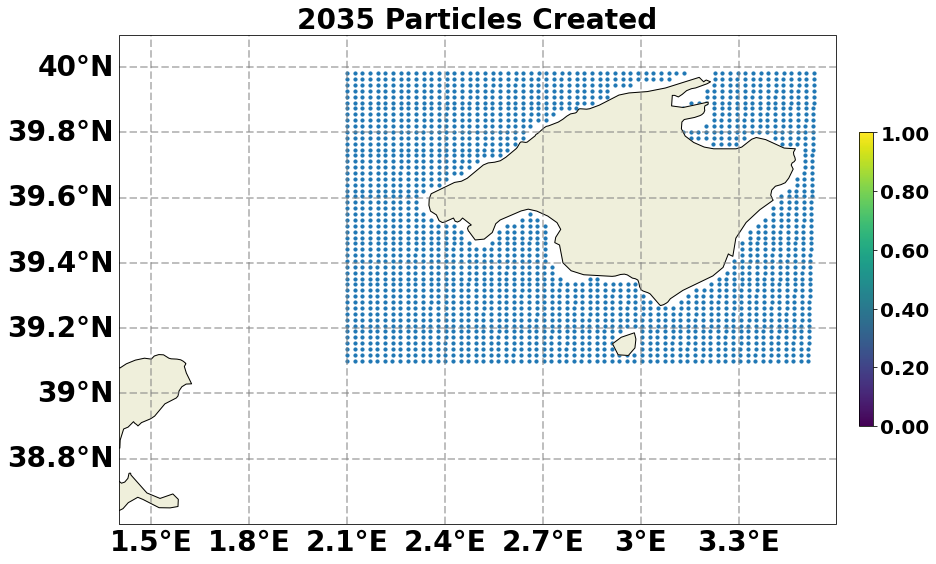

In [18]:
reference = (39.1, 2.1)
shape = (50, 62)  # 30 particles over latitude and 50 particles over longitude (depth is optional)
lat_separation = 2_000  # in meters
lon_separation = 2_000  # in meters
depth_separation = 10

lats, lons, depths = GenerateParticles.regular_grid(reference=reference, shape=shape,
                                                    lat_separation=lat_separation, lon_separation=lon_separation, depth_separation=depth_separation,
                                                    land_mask=wmop.land_mask, land_mask_coords=land_mask_coords)
plot_points_map(lons, lats, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

#### Associating Particles

The method `associate_particles` from GenerateParticles creates a new set of particles with a main objective: be a reference for a original particle.

In [19]:
particles = (lats, lons, depths)

In [20]:
updated_particles, association_dataset = GenerateParticles.associate_particles(particles, 4, distance=30_000, land_mask=wmop.land_mask, land_mask_coords=land_mask_coords)

In [21]:
association_dataset

<xarray.Dataset>
Dimensions:        (association: 4, location: 3, particle: 2035, particles_associated: 3939)
Coordinates:
    particle_id    (particle) int64 0 1 2 3 4 5 ... 2030 2031 2032 2033 2034
    associated_id  (particles_associated) int64 2035 2036 2037 ... 5972 5973
Dimensions without coordinates: association, location, particle, particles_associated
Data variables:
    associations   (particle, association) float64 2.035e+03 2.036e+03 ... -1.0
    particles      (particle, location) float64 39.1 2.1 0.0 ... 39.98 3.532 0.0
    associated     (particles_associated, location) float64 39.37 2.1 ... 0.0

In [22]:
plot_points_map(association_dataset.associated.values[:, 1], association_dataset.associated.values[:, 0], show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

#### **Generating particles from list**

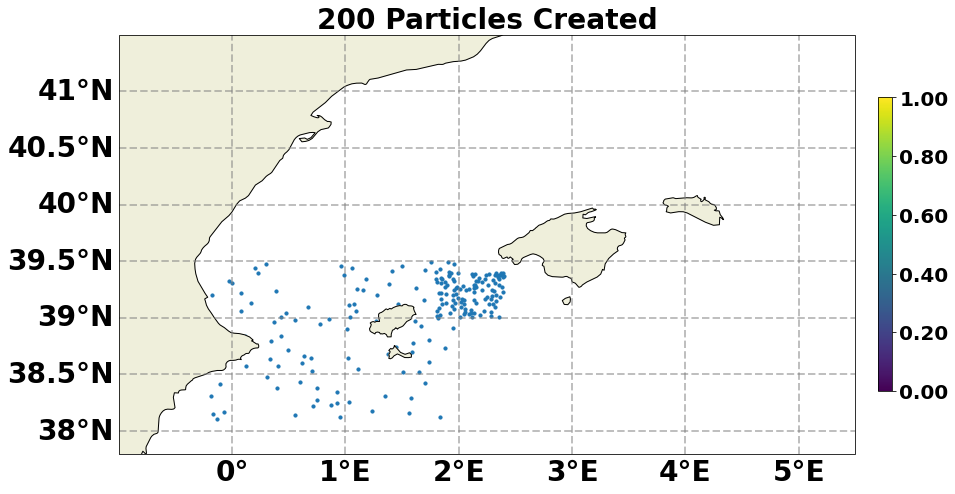

In [23]:
n_particles = 100
lat_limits = (39, 39.4)
lon_limits = (1.8, 2.4)
lats_mallorca, lons_mallorca, depths_mallorca = GenerateParticles.random(n_particles, lat_limits=lat_limits, lon_limits=lon_limits)
lats_ibiza, lons_ibiza, depths_ibiza = GenerateParticles.random(n_particles, region='IbizaChannel')
lats, lons, depths = GenerateParticles.from_list(np.concatenate((lats_mallorca, lats_ibiza)), np.concatenate((lons_mallorca, lons_ibiza)), np.concatenate((depths_mallorca, depths_ibiza)))
plot_points_map(lons, lats, show=True, region='BalearicIslands', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

### **Using custom mask to filter particles**

#### A bathymetric mask

In [24]:
Hbath = NearestNDInterpolator((grid.lon_rho.values.flatten(), grid.lat_rho.values.flatten()), grid.h.values.flatten())

In [25]:
X, Y = np.meshgrid(wmop.lon.values, wmop.lat.values)
bath = Hbath(X, Y)

In [26]:
wmop["h"] = xr.DataArray(bath, coords=[wmop.lat.values, wmop.lon.values], dims=["lat", "lon"])

#### Custom mask filtering points on land and water points with depth higher than 200 meters

In [27]:
custom_mask = (wmop.land_mask.sel(depth=0).values == 1) | (wmop.h.values > 200)
custom_mask = xr.DataArray(custom_mask, coords=[wmop.lat.values, wmop.lon.values], dims=["lat", "lon"])

custom_mask_coord = {
    'latitude': 'lat',
    'longitude': 'lon'
}

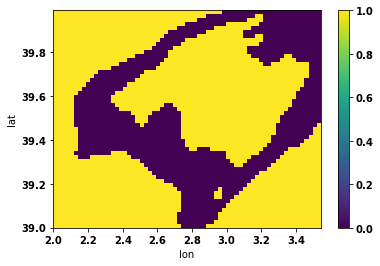

In [28]:
custom_mask.plot()

In [29]:
reference = (39.1, 2.1)
shape = (50, 62)  # 30 particles over latitude and 50 particles over longitude (depth is optional)
lat_separation = 2_000  # in meters
lon_separation = 2_000  # in meters
depth_separation = 10

lats, lons, depths = GenerateParticles.regular_grid(reference=reference, shape=shape,
                                                    lat_separation=lat_separation, lon_separation=lon_separation, depth_separation=depth_separation,
                                                    land_mask=custom_mask, land_mask_coords=custom_mask_coord)
plot_points_map(lons, lats, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

#### A speed mask

In [30]:
speed = np.sqrt(wmop["u"]*wmop["u"] + wmop["v"]*wmop["v"]).isel(ocean_time=0)

In [31]:
speed.isel(depth=0).plot()

#### Custom mask filtering points on land and water points with current speed lower than 0.3 m/s

In [32]:
custom_mask = (wmop.land_mask.sel(depth=0).values == 1) | (speed.values < 0.3)
custom_mask = xr.DataArray(custom_mask, coords=[wmop.depth.values, wmop.lat.values, wmop.lon.values], dims=["depth", "lat", "lon"])

custom_mask_coord = {
    'latitude': 'lat',
    'longitude': 'lon',
    'depth': 'depth'
}

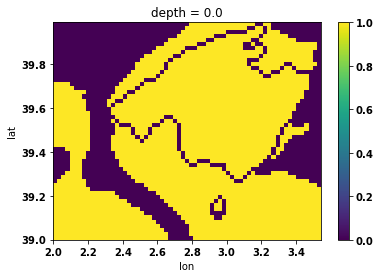

In [33]:
custom_mask.sel(depth=0).plot()

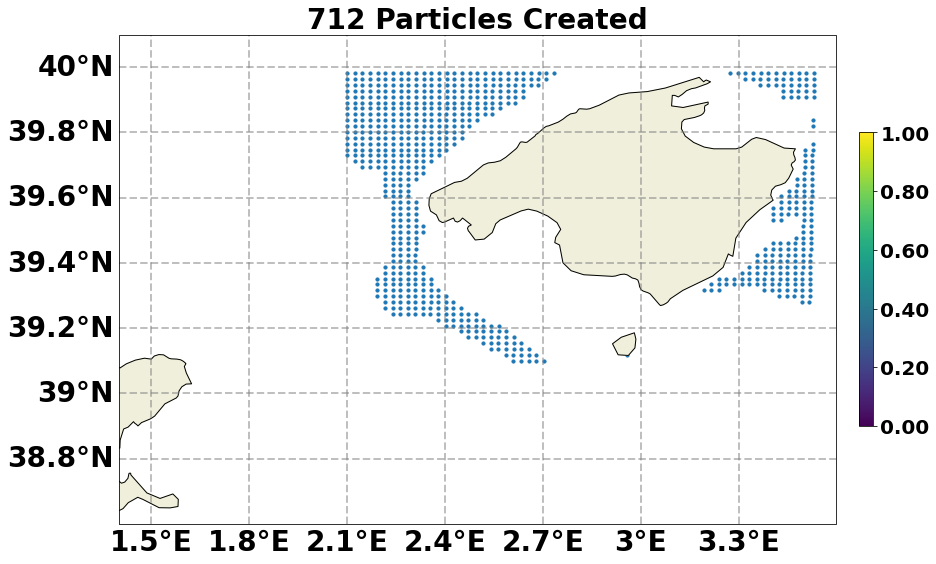

In [34]:
reference = (39.1, 2.1)
shape = (50, 62)  # 30 particles over latitude and 50 particles over longitude (depth is optional)
lat_separation = 2_000  # in meters
lon_separation = 2_000  # in meters
depth_separation = 10

lats, lons, depths = GenerateParticles.regular_grid(reference=reference, shape=shape,
                                                    lat_separation=lat_separation, lon_separation=lon_separation, depth_separation=depth_separation,
                                                    land_mask=custom_mask, land_mask_coords=custom_mask_coord)
plot_points_map(lons, lats, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')